# 6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
%matplotlib inline

In [2]:
customers = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_customers_dataset.csv')
order_items = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_order_items_dataset.csv')
orders = pd.read_csv('/home/oleg/Downloads/karpov_courses-main/\
Промежуточный проект/datasets/olist_orders_dataset.csv')

## Подготовим данные

Для этого уберем все незавершенные заказы.

In [3]:
cust_orders = customers.merge(orders, on='customer_id')
cust_orders = cust_orders.merge(order_items)[['customer_unique_id', 'price', 'order_purchase_timestamp', 'order_id', 'order_status']]
cust_orders = cust_orders.query('order_status not in ("canceled", \
                                                      "unavailable", \
                                                      "invoiced", \
                                                      "processing", \
                                                      "created", \
                                                      "approved", \
                                                      "shipped")')
cust_orders.head()

,customer_unique_id,price,order_purchase_timestamp,order_id,order_status
0,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,delivered
1,290c77bc529b7ac935b93aa66c333dc3,289.00,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered
3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba,delivered
4,345ecd01c38d18a9036ed96c73b8d066,230.00,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered


In [4]:
cust_orders = cust_orders.rename(columns={'customer_unique_id' : 'customer_id', 
                                         'order_purchase_timestamp' : 'order_date'})
cust_orders.head()

,customer_id,price,order_date,order_id,order_status
0,861eff4711a542e4b93843c6dd7febb0,124.99,2017-05-16 15:05:35,00e7ee1b050b8499577073aeb2a297a1,delivered
1,290c77bc529b7ac935b93aa66c333dc3,289.00,2018-01-12 20:48:24,29150127e6685892b6eab3eec79f59c7,delivered
2,060e732b5b29e8181a18229c7b0b2b5e,139.94,2018-05-19 16:07:45,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered
3,259dac757896d24d7702b9acbbff3f3c,149.94,2018-03-13 16:06:38,951670f92359f4fe4a63112aa7306eba,delivered
4,345ecd01c38d18a9036ed96c73b8d066,230.00,2018-07-29 09:51:30,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered


In [5]:
cust_orders.shape[0]

110197

In [6]:
cust_orders['order_date'] = pd.to_datetime(cust_orders['order_date'])


В качестве даты, относительно которой пойдет отсчет, будем считать дату последней покупки + 1 день.


In [7]:
now_date = cust_orders.order_date.max() + dt.timedelta(days=1)
now_date

Timestamp('2018-08-30 15:00:37')

## Посчитаем все необходимые метрики



Recency - дельта, которая показывает, когда была совершена последняя покупка. 

Frequency - считаем число заказов на одного пользователя.

Monetary - считаем суммарную сумму, потраченную пользователем.


In [8]:
recency = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'order_date' : lambda x : (now_date - x.max()).days})\
    .rename(columns={'order_date' : 'recency'})
recency.head()

,customer_id,recency
0,0000366f3b9a7992bf8c76cfdf3221e2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115
2,0000f46a3911fa3c0805444483337064,537
3,0000f6ccb0745a6a4b88665a16c9f078,321
4,0004aac84e0df4da2b147fca70cf8255,288


In [9]:
frequency = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'order_id' : 'count'})\
    .rename(columns={'order_id' : 'frequency'})
frequency.head()

,customer_id,frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [10]:
monetary = cust_orders\
    .groupby('customer_id', as_index=False)\
    .agg({'price' : 'sum'})\
    .rename(columns={'price' : 'monetary'})
monetary.head()

,customer_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


Объединим все в один датафрейм для RFM-анализа.

In [11]:
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')
rfm.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


Визуализируем и изучим отдельно каждую метрику.

## Recency

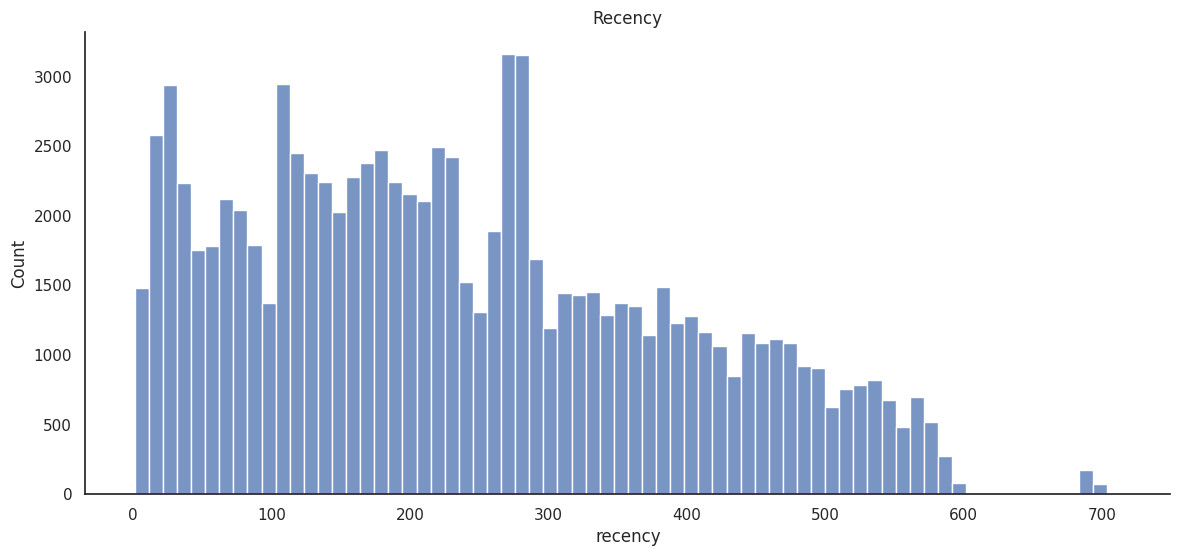

In [33]:
fig, ax = plt.subplots(figsize=(14,6))
sns.set_theme()
sns.histplot(data=rfm.recency)
ax.set_title('Recency')
sns.despine()

In [14]:
print(rfm.recency.quantile(q=.33))
print(rfm.recency.quantile(q=.66))

147.0
286.0


Разобъем Recency на три периода. Последний будет лежать за отметкой в 286 дня, как показал нам квантиль=0.66, граница первого закончится на границе квантиля в 0.33.

In [15]:
def R(recency):
    if recency <= 147:
        return 3
    elif 147 < recency <= 286:
        return 2
    else:
        return 1

In [16]:
rfm['r'] = rfm.recency.apply(R)
rfm.head()

,customer_id,recency,frequency,monetary,r
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1


# Frequency

In [17]:
print(rfm.frequency.value_counts().to_list()[0] / sum(rfm.frequency.value_counts().to_list()[:]) * 100)

87.56400094260802


Почти 88% покупателей совершили только одну покупку.

Разобьем Frequency также на 3 группы:
- 1 - 1 покупка; 
- 2 - 2 покупки; 
- 3 - 3 покупки и более

In [18]:
def F(frequency):
    if frequency == 1:
        return 1
    elif frequency == 2:
        return 2
    else:
        return 3

In [19]:
rfm['f'] = rfm.frequency.apply(F)
rfm.head()

,customer_id,recency,frequency,monetary,r,f
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1


# Monetary

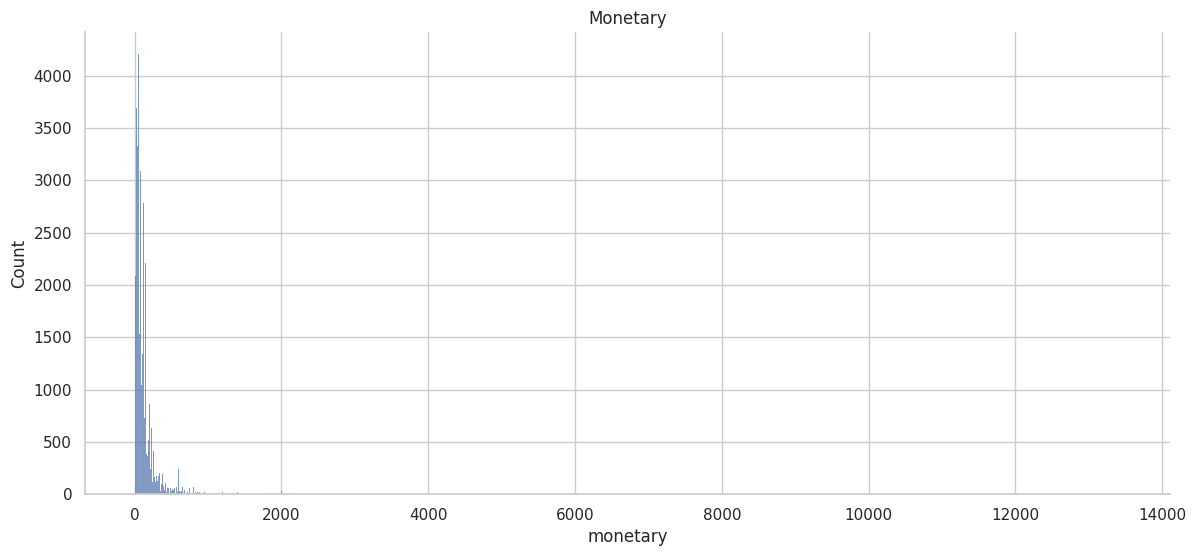

In [20]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(rfm.monetary)
ax.set_title('Monetary')
#ax.set_xlim(0,1500)
sns.despine()

In [21]:
rfm.monetary.describe()

count    93358.000000
mean       141.621480
std        215.694014
min          0.850000
25%         47.650000
50%         89.730000
75%        154.737500
max      13440.000000
Name: monetary, dtype: float64

Также разобьем Monetary на 3 группы:
- 1 - тратят до 100 у.е; 
- 2 - тратят от 100 до 1000 у.е; 
- 3 - тратят 1000 у.е. и более 

In [22]:
def M(monetary):
    if monetary < 100:
        return 1
    elif 100 <= monetary < 1000:
        return 2
    else: 
        return 3

In [23]:
rfm['m'] = rfm.monetary.apply(M)
rfm.head()

,customer_id,recency,frequency,monetary,r,f,m
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,2


## Получим результирующую таблицу с разбивкой на кластеры RFM и сделаем визуализацию

In [24]:
rfm['RFM'] = rfm['r'].astype('str') + rfm['f'].astype('str') + rfm['m'].astype('str')
rfm.head()

,customer_id,recency,frequency,monetary,r,f,m,RFM
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,1,1,2,112


Для каждого кластера выведем средние значения

In [25]:
rfm_groupped = rfm\
    .groupby('RFM', as_index=False)\
    .agg({'recency' : 'mean', 'frequency' : 'mean', 'monetary' : 'mean'}).round(2)
rfm_groupped.head()

,RFM,recency,frequency,monetary
0,111,415.84,1.0,53.17
1,112,416.59,1.0,227.83
2,113,413.14,1.0,1603.14
3,121,417.97,2.0,62.09
4,122,408.94,2.0,232.93


In [26]:
rfm_groupped.value_counts().count()

27

In [27]:
rfm_num_customers = rfm\
    .groupby('RFM', as_index=False)\
    .agg(num_of_customers=('customer_id', 'count'))
rfm_num_customers.head()

,RFM,num_of_customers
0,111,17301
1,112,10261
2,113,285
3,121,1169
4,122,1758


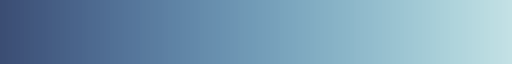

In [37]:
sns.color_palette("ch:r=-.2,d=.3_r", as_cmap=True)

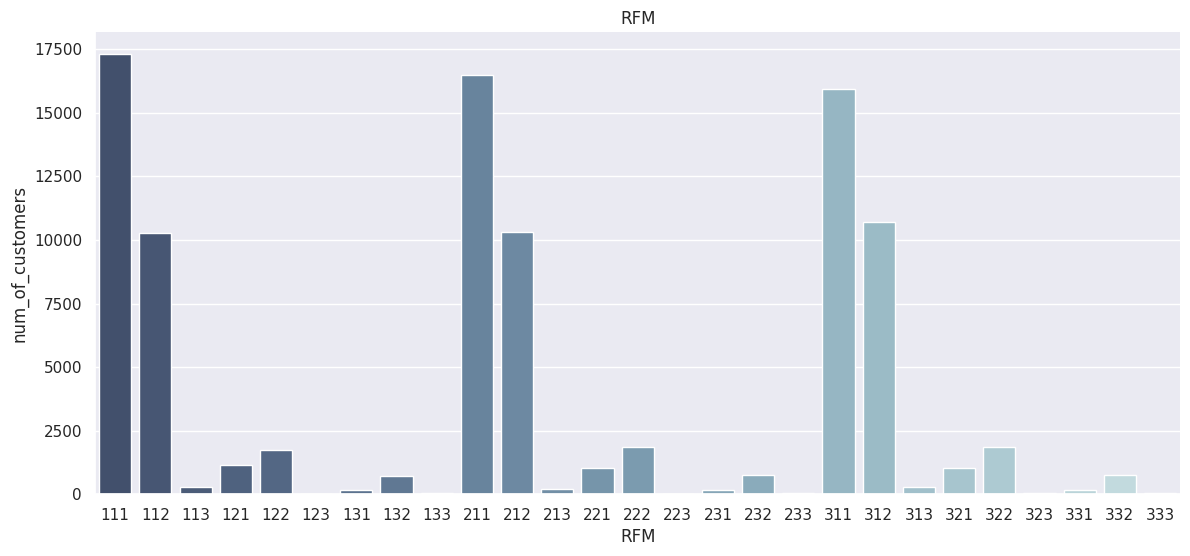

In [38]:
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(data=rfm_num_customers, x='RFM', y='num_of_customers', palette="ch:r=-.2,d=.3_r")
ax.set_title('RFM')
sns.despine()